# Bonus1: Parallel Algorithms: Decentralized Optimization

### Name: [Yupeng Cao]
### ID: 10454637


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()
y = y.reshape(y.shape[0], 1)

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768, 1)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.05342471  0.03318513 -0.13301829  0.10122877  0.20844993 -0.02141061
   0.21638939 -0.08634909]]
test std = 
[[1.10756643 0.97826501 1.22247494 0.88011594 1.22863828 1.11168939
  1.05711972 0.90654133]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [6]:
"""
Some code and Function/Variable naming is refering from HW1.
"""

class Worker:
    
    def __init__ (self, x, y):
        self.x = x #s-by-d
        self.y = y #s-by-1
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((self.d, 1)) #d-by-1
        self.nbr_nodes = [] # list of neighbors
        
    # Set the model parameters to the latest
    def set_param(self , w): 
        self.w = w
        
    # Boradcost weight to neighbor nodes    
    def get_w(self):
        return self.w
    
    # Set neighbor workers
    def set_nbr_node(self, nbr_nodes):
        self.nbr_nodes.extend(nbr_nodes)
        
    # Get neighbor workers
    def get_nbr_node(self):
        return self.nbr_nodes
    
    # Compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d 
        yxw = numpy.dot(yx, self.w) # s−by−1 
        vec1 = numpy.exp(-yxw) # s−by−1 
        vec2 = numpy.log(1 + vec1) # s−by−1 
        return numpy.sum(vec2) 

    # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        return g
    
    # Compute gradient descent
    def grad_descent(self, stepsize):
        g = self.gradient()
        self.w -= stepsize * g
        return self.w
    

In [7]:
import math

# Create a server and m worker nodes
def create_neighbor_workers(m, x, y): 
    n, d = x.shape
    s = math.floor(n / m) 
    workers = []
    
    # assign training data to each worker
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = Worker(x[indices, :], y[indices, :]) 
        workers.append(worker)
    
    #Based on the digram in lecture notes to set neighbor nodes.
    workers[0].set_nbr_node([1, 2])
    workers[1].set_nbr_node([0, 2])
    workers[2].set_nbr_node([0, 1, 4])
    workers[3].set_nbr_node([1, 4])
    workers[4].set_nbr_node([2, 3, 5, 6])
    workers[5].set_nbr_node([4, 6])
    workers[6].set_nbr_node([4, 5])
    
    return workers

In [8]:
# Calculate losses value for whole dataset at each step
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d 
    yxw = numpy.dot(yx, w) # n-by-1 
    vec1 = numpy.exp(-yxw) # n-by-1 
    vec2 = numpy.log(1 + vec1) # n-by-1 
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg

In [9]:
lam = 1E-3 
max_epoch = 100 
stepsize = 10e-4 
m = 7 # number of worker nodes

In [10]:
def decentralized_gd_avg():
    n = x_train.shape[1]
    workers = create_neighbor_workers(m, x_train , y_train)

    obj_values = []
    for t in range(max_epoch): 
        # Get neighbor's w and calculate new_w at local
        for i in range(m):
            nbrs = workers[i].get_nbr_node()
            new_w = numpy.zeros((x_train.shape[1], 1))
            for j in nbrs:
                new_w += (workers[j].get_w())
            
            # Update worker's local weights
            new_w += workers[i].get_w()
            new_w /= len(nbrs) + 1
            workers[i].set_param(new_w)

        # Workers' local losses computation
        avg = numpy.zeros((n, 1))
        losses = []
        
        # Calculate local weight for each worker node
        for i in range(m): 
            w_t = workers[i].grad_descent(stepsize) 
            avg += w_t  
            
        avg /= m
        obj = objective(avg, x_train, y_train, lam)
        obj_values.append(obj)
        print('Objective function value = ' + str(obj))
        
    return obj_values

In [11]:
avg = decentralized_gd_avg()

Objective function value = 0.6810633379896949
Objective function value = 0.6699711936667957
Objective function value = 0.6596984849917555
Objective function value = 0.650171097605614
Objective function value = 0.6413237716081679
Objective function value = 0.6330962972558668
Objective function value = 0.6254338277748271
Objective function value = 0.618286661315128
Objective function value = 0.6116098365359627
Objective function value = 0.6053627204038675
Objective function value = 0.599508618607348
Objective function value = 0.5940144091869014
Objective function value = 0.5888501990711166
Objective function value = 0.5839890046037999
Objective function value = 0.5794064571873153
Objective function value = 0.5750805344516897
Objective function value = 0.5709913165378844
Objective function value = 0.5671207664295169
Objective function value = 0.5634525328353088
Objective function value = 0.5599717738863873
Objective function value = 0.5566649998199313
Objective function value = 0.55351993

In [12]:
def decentralized_gd_weighted_avg(weighted):
    n = x_train.shape[1]
    workers = create_neighbor_workers(m, x_train , y_train)

    obj_values = []
    for t in range(max_epoch): 
        # Get neighbor's w and calculate new_w at local
        for i in range(m):
            nbrs = workers[i].get_nbr_node()
            new_w = numpy.zeros((x_train.shape[1], 1))
            for j in nbrs:
                new_w += (workers[j].get_w())
            
            # Update worker's local weights
            new_w = weighted * new_w
            new_w += weighted * (workers[i].get_w())
            new_w /= weighted * (len(nbrs) + 1)
            workers[i].set_param(new_w)

        # Workers' local losses computation
        avg = numpy.zeros((n, 1))
        losses = []
        
        # Calculate local weight for each worker node
        for i in range(m): 
            w_t = workers[i].grad_descent(stepsize) 
            avg += w_t  
            
        avg /= m
        obj = objective(avg, x_train, y_train, lam)
        obj_values.append(obj)
        print('Weighted =' + str(weighted) + ', Objective function value = ' + str(obj))
        
    return obj_values

In [13]:
w_avg_1 = decentralized_gd_weighted_avg(1)
w_avg_2 = decentralized_gd_weighted_avg(2)
w_avg_3 = decentralized_gd_weighted_avg(3)

Weighted =1, Objective function value = 0.6810633379896949
Weighted =1, Objective function value = 0.6699711936667957
Weighted =1, Objective function value = 0.6596984849917555
Weighted =1, Objective function value = 0.650171097605614
Weighted =1, Objective function value = 0.6413237716081679
Weighted =1, Objective function value = 0.6330962972558668
Weighted =1, Objective function value = 0.6254338277748271
Weighted =1, Objective function value = 0.618286661315128
Weighted =1, Objective function value = 0.6116098365359627
Weighted =1, Objective function value = 0.6053627204038675
Weighted =1, Objective function value = 0.599508618607348
Weighted =1, Objective function value = 0.5940144091869014
Weighted =1, Objective function value = 0.5888501990711166
Weighted =1, Objective function value = 0.5839890046037999
Weighted =1, Objective function value = 0.5794064571873153
Weighted =1, Objective function value = 0.5750805344516897
Weighted =1, Objective function value = 0.5709913165378844


Weighted =3, Objective function value = 0.47657105243055303
Weighted =3, Objective function value = 0.4762121884383119
Weighted =3, Objective function value = 0.47586099937228415
Weighted =3, Objective function value = 0.4755172818255326
Weighted =3, Objective function value = 0.475180839207842
Weighted =3, Objective function value = 0.47485148145922657
Weighted =3, Objective function value = 0.47452902477811737
Weighted =3, Objective function value = 0.47421329136334633
Weighted =3, Objective function value = 0.4739041091691019


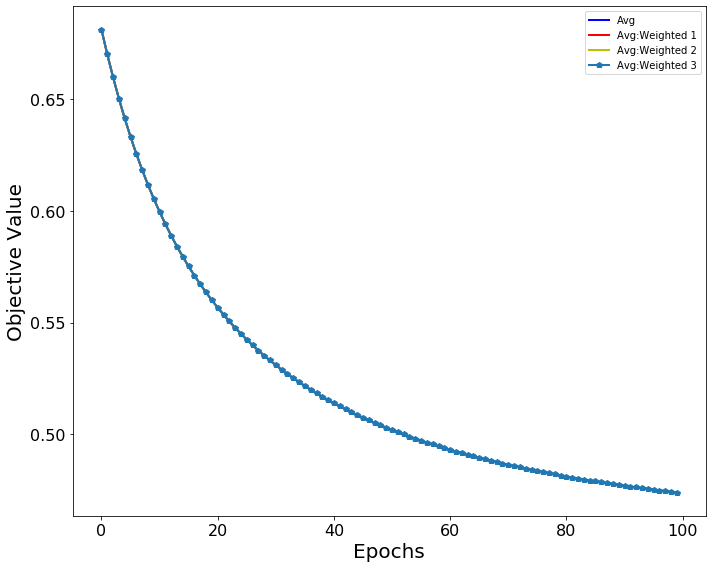

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
epochs_len = range(len(avg))

line0, = plt.plot(epochs_len, avg, '-b', LineWidth=2)
line1, = plt.plot(epochs_len, w_avg_1, '-r', LineWidth=2)
line2, = plt.plot(epochs_len, w_avg_2, '-y', LineWidth=2)
line3, = plt.plot(epochs_len, w_avg_3, '-p', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1,line2,line3], ['Avg', 'Avg:Weighted 1','Avg:Weighted 2','Avg:Weighted 3'], fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig('decentralized optimization compare.pdf', format='pdf')